In [14]:
# 基于B样条的可变性配准
import SimpleITK as sitk
import matplotlib.pyplot as plt

# 读取两张不同模态的二维BMP图像
moving_image = sitk.ReadImage("images/deformable/bse.bmp", sitk.sitkFloat32)
fixed_image = sitk.ReadImage("images/deformable/ct.bmp", sitk.sitkFloat32)

In [ ]:
# 初始化注册方法
registration_method = sitk.ImageRegistrationMethod()

# 设置图像金字塔策略
registration_method.SetShrinkFactorsPerLevel([4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel([2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# 设置配准的初始变换，仿射变换作为初始化
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.AffineTransform(2), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)

# 使用Mattes互信息作为度量指标
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

# 使用LBFGSB优化器
number_of_parameters = initial_transform.GetNumberOfParameters()
lower_bounds = [-10.0] * number_of_parameters  # 下界
upper_bounds = [10.0] * number_of_parameters   # 上界

registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                                         numberOfIterations=100,
                                         maximumNumberOfCorrections=5,
                                         maximumNumberOfFunctionEvaluations=1000,
                                         costFunctionConvergenceFactor=1e7,
                                         lowerBound = lower_bounds,
                                         upperBound = upper_bounds
                                         )

# 设置优化器的平滑因子
registration_method.SetOptimizerScalesFromPhysicalShift()

# 使用B样条作为最终的变换模型
grid_physical_spacing = [50.0, 50.0] # 设置B样条网格的物理间隔
image_physical_size = [size*spacing for size, spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
mesh_size = [int(image_size/grid_spacing + 0.5) for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)]

bspline_transform = sitk.BSplineTransformInitializer(fixed_image, 
                                                     transformDomainMeshSize=mesh_size, 
                                                     order=3)

registration_method.SetMovingInitialTransform(initial_transform)
registration_method.SetInitialTransformAsBSpline(bspline_transform, inPlace=True, scaleFactors=[1, 2, 3])

# 设置采样器
registration_method.SetInterpolator(sitk.sitkLinear)

In [ ]:
# 执行配准
final_transform = registration_method.Execute(fixed_image, moving_image)

# 打印最终的变换参数
print("Final metric value: {0}".format(registration_method.GetMetricValue()))
print("Optimizer's stopping condition, {0}".format(registration_method.GetOptimizerStopConditionDescription()))


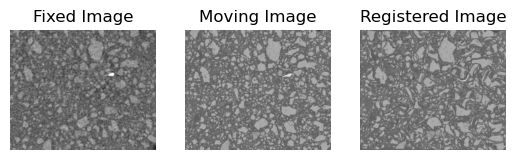

In [10]:
# 将移动图像应用于最终变换
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(final_transform)

out = resampler.Execute(moving_image)

# 保存配准结果
# sitk.WriteImage(out, "output_image.bmp")

# 可视化配准结果
import matplotlib.pyplot as plt

def show_images(image_list, title_list):
    for i, image in enumerate(image_list):
        plt.subplot(1, len(image_list), i+1)
        plt.imshow(sitk.GetArrayViewFromImage(image), cmap='gray', vmin=0, vmax=255)
        plt.title(title_list[i])
        plt.axis('off')
    plt.show()

show_images([fixed_image, moving_image, out], ['Fixed Image', 'Moving Image', 'Registered Image'])
